# Deep Symbolic Learning
Ruchi Gupte

In [2]:
import numpy as np
from numpy import asarray,save,load
from numpy.lib.stride_tricks import as_strided
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import MeanShift
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.neighbors import NearestCentroid
import idx2numpy
import pickle
from PIL import Image
import cv2
import json
import math
import glob
import random
import sklearn
import time

In [3]:
config = {"training_image_path"             : "Jio_imagepath/FASHION_MNIST/train-images-idx3-ubyte", 
          "load_path"                       : "_5x5_FashMNIST_Kmeans", 
          "test_image_path"                 : "Jio_imagepath/FASHION_MNIST/t10k-images-idx3-ubyte", 
          "genral_path_incase_of_folder"    : "Jio_imagepath/New", 
          "dataset_format"                  : "ubyte", 
          "sampleimages"                    : 1000, 
          "window_size"                     : 5, 
          "Stride"                          : 3, 
          "padding"                         : [0, 1, 0, 1], 
          "image_size"                      : 28, 
          "clustering_model"                : "KMEANS", 
          "n_clusters"                      : 150, 
          "bandwidth"                       : 300, 
          "test_skip"                       : 2, 
          "Consistency_formula"             : "NPMI", 
          "model_load"                      : 0, 
          "neighbor_range"                  : 2, }
with open('config.json', 'w') as f:
        json.dump(config, f)

# Stage 0 : Read Stage
Taking input as config.json file, take test images and load them and store them

In [11]:
#INPUT----------------------------------
with open('config.json', 'r') as f:
        config = json.load(f)
load_path=config['load_path']
padding=config['padding'] #Padding per image incase of uneven strides
no_of_sampleimages=config['sampleimages']
type_dataset=config['dataset_format']  #The path and file type of dataset
#INPUT----------------------------------

In [12]:
if type_dataset=='folder': #Incase dataset is a set of images in a folder
    final_image_list = []
    for img in glob.glob(config['genral_path_incase_of_folder']+'/*.jpg*'):
        temp_image= cv2.imread(img,0)
        final_image_list.append(temp_image)
    #random.shuffle(final_image_list) #Incase you want to shuffle dataset
    testdata, traindata = sklearn.model_selection.train_test_split(final_image_list, train_size=0.4, test_size=0.6)

elif type_dataset=='ubyte': #In case of MNIS, images are stored in ubyte folder
    traindata = idx2numpy.convert_from_file(config['training_image_path']) 
    testdata = idx2numpy.convert_from_file(config['test_image_path']) 
    
else:
    print("Error in Reading Images in Stage 0")
print(str(len(traindata))+" training images and "+str(len(testdata))+" test images added")

60000 training images and 10000 test images added


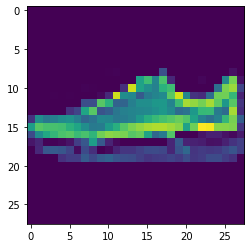

In [7]:
plt.imshow(testdata[9])  #show patch in dataset

In [8]:
traindata = traindata[:no_of_sampleimages]
testdata = testdata[:no_of_sampleimages]

In [13]:
#Padding
final_train_data=[0]*no_of_sampleimages #Inserting padding to each image
for k in range(no_of_sampleimages):
    final_train_data[k]=np.pad(traindata[k], [(padding[0], padding[1]), (padding[2], padding[3])], mode='constant', constant_values=0)
        
final_test_data=[0]*no_of_sampleimages  #Inserting padding to each image
for k in range(no_of_sampleimages):
    final_test_data[k]=np.pad(traindata[k], [(padding[0], padding[1]), (padding[2], padding[3])], mode='constant', constant_values=0)

In [14]:
#OUTPUT-------------------------------------------
np.save('Array_of_training_images'+load_path+'temp.npy', final_train_data)  #Remove temp for final
np.save('Array_of_test_images'+load_path+'temp.npy', final_test_data)
print("Stage 0 Completed Succesfully!")
#OUTPUT-------------------------------------------

Stage 0 Completed Succesfully!


# Stage 1 :Low Level Feature extraction
Taking input as config.json and training data, convert data into patches and store them and store them

In [15]:
#INPUT----------------------------------
with open('config.json', 'r') as f:
        config = json.load(f)
load_path=config['load_path']
widthi=heighti=config['image_size'] #Height and width of input image
no_of_sampleimages=config['sampleimages']
patch_size=config['window_size'] #Size of patches to consider
shift=config['Stride']  #Stride for each patch
padding=config['padding']
data = np.load('Array_of_training_images'+load_path+'.npy')
#INPUT----------------------------------

In [16]:
X_im=[]
for k in range(no_of_sampleimages):
    patchl=0
    patchh=0
    image=data[k]
    for i in range(0,heighti+padding[0]+padding[1]-(patch_size-1),shift):
        for j in range(0,widthi+padding[2]+padding[3]-(patch_size-1),shift):
            BLOCK=image[i:i+patch_size,j:j+patch_size]
            X_im.append(BLOCK) 
            patchl=patchl+1
        patchh=patchh+1
        
patchl=int(patchl/patchh)
X_im = np.array(X_im)

In [17]:
len(X_im)

81000

In [20]:
imageno=153 #Select which image in dataset
patchno=patchl*patchh
image=X_im[patchno*imageno:patchno*(imageno+1)]
BLUE = [255,255,255]
size = 100, 100

new_im = Image.new('RGBA', (patchh*100, patchl*100), (255, 255, 255, 255))
k=0
for i in range(0,patchh*100,100):
    for j in range(0,patchl*100,100):
        im=cv2.copyMakeBorder(image[k],0,1,0,1,cv2.BORDER_CONSTANT,value=BLUE)
        ima = Image.fromarray(im, 'L')
        im = ima.resize((100,100), resample=Image.NEAREST)
        k=k+1
        new_im.paste(im, (j,i))
               
new_im.show()

In [21]:
#OUTPUT-------------------------------------------
config.update( {'patchl' : patchl, # Adding patch length to config
                'patchh' : patchh} ) #Adding patch height to config
with open('config.json', 'w') as f:
        json.dump(config, f)
np.save('patchlist'+load_path+'temp.npy', X_im) #Remove temp for final
print("Stage 1 Completed Succesfully!")
#OUTPUT-------------------------------------------

Stage 1 Completed Succesfully!


# Stage 2: Symbolic ID Creation
Taking input as config.json and data of image patches, perform clustering on them and gather data like centroids, distances and assign each patch to a appropriate cluster.

In [22]:
#INPUT----------------------------------
with open('config.json', 'r') as f:
        config = json.load(f)
load_path=config['load_path']
patchlist = np.load('patchlist'+load_path+'.npy')
patch_size=config['window_size']
#INPUT---------------------------------

In [24]:
stage2_load_condition=1   # 1 to load from pre existing model and 0 for new training

In [26]:
if stage2_load_condition==1:
    print("Loading model from file....")
    model = pickle.load(open('model'+load_path+'.sav', 'rb'))
    n_clusters=config['n_clusters']
    labels=model.labels_
    centroids = model.cluster_centers_
    print("Loaded")
        
else:
    if config['clustering_model']=='KMEANS':
        time_start = time.time()
        n_clusters=config['n_clusters']
        model = KMeans(n_clusters=n_clusters, n_init=10, max_iter=300, tol=1e-4, verbose=0, random_state=None, copy_x=True, algorithm="auto")
        model=model.fit(patchlist.reshape(len(patchlist),-1))
        labels=model.labels_
        centroids = model.cluster_centers_
        print("Kmeans Done. Time elapsed: {} minutes".format((time.time()-time_start)/60))
        print(time.time()-time_start)
        
    elif config['clustering_model']=='MEANSHIFT':
        time_start = time.time()
        bandwidth=config['bandwidth']
        model = MeanShift(bandwidth=bandwidth, bin_seeding=False, cluster_all=True, min_bin_freq=1, n_jobs=1, seeds= None)
        model=model.fit(patchlist.reshape(len(patchlist),-1))
        labels = model.labels_
        centroids = model.cluster_centers_
        labels_unique = np.unique(labels)
        n_clusters = len(labels_unique)
        config.update( {'n_clusters' : n_clusters} )
        print ("MeanShift Done. Time elapsed: {} minutes".format((time.time()-time_start)/60))
        print(time.time()-time_start)

Loading model from file....
Loaded


In [27]:
model.get_params() 

{'algorithm': 'auto',
 'copy_x': True,
 'init': 'k-means++',
 'max_iter': 300,
 'n_clusters': 150,
 'n_init': 10,
 'n_jobs': 'deprecated',
 'precompute_distances': 'deprecated',
 'random_state': None,
 'tol': 0.0001,
 'verbose': 0}

In [73]:
def Sort(sub_li): 
    sub_li.sort(key = lambda x: x[1]) 
    return sub_li 

In [74]:
k=0
clusterdata=[]
for clus in range(n_clusters):
    for i in patchlist[np.where(labels==clus)]:
        k=k+1
    temp=[clus+1,k]
    clusterdata.append(temp)   
    k=0 #comment to check cumulative density 
clusterdata=Sort(clusterdata)

In [28]:
#for i in range(n_clusters, 0, -1):
    #print(clusterdata[i-1][0],'   :  ', clusterdata[i-1][1])

In [76]:
temp=[]
clustack=[]
for clus in range(n_clusters):
    for i in patchlist[np.where(labels==clus)]:
        temp.append(i)
    clustack.append(np.array(temp))
    temp=[]
clustack=np.array(clustack)

In [77]:
dist=[]
for Clusterno in range(n_clusters):
    temp=[]
    Cent=centroids[Clusterno].reshape(patch_size,patch_size)
    k=0
    for m in clustack[Clusterno]:
        distance = np.linalg.norm(m-Cent)
        distance=[int(k),int(distance)]
        temp.append(distance)
        k=k+1
    dist.append(temp)
for clus in range(n_clusters):
    dist[clus]=np.array(Sort(dist[clus]))

In [85]:
cluster_no=18 # cluster number

Rows=10  #how many rows and columns in collage
Columns=10
Background_white = [255,255,255]
final_collage = Image.new('RGBA', (1000, 1000), (255, 255,255))
k=0

for i in range(0,Columns*100,100):
    for j in range(0,Rows*100,100):
        temp_image=cv2.copyMakeBorder(clustack[cluster_no-1][int(dist[cluster_no-1][k][0])],0,1,0,1,cv2.BORDER_CONSTANT,value=Background_white)
        temp_image = Image.fromarray(temp_image, 'L')
        temp_image = temp_image.resize((100,100), resample=Image.NEAREST)
        k=k+1
        final_collage.paste(temp_image, (j,i))

final_collage.show()

In [22]:
#OUTPUT------------------------ Remove temp for final-------------
np.save('cluster_density'+load_path+'temp.npy', clusterdata)
np.save('patch_with_clusters'+load_path+'temp.npy', clustack)
np.save('distance_info_for_clusters'+load_path+'temp.npy', dist)
pickle.dump(model, open('model'+load_path+'temp.sav', 'wb'))
print("Stage 2 Completed Succesfully!")
#OUTPUT-----------------------------------------------------------

# Stage 3 : Symbolic ID Assignment
Taking input as config.json, model, its parameters, and test data, convert them to a symbolic matrix using the model from the training images.

In [31]:
#INPUT----------------------------------------------------
with open('config.json', 'r') as f:
        config = json.load(f)
load_path=config['load_path']
model = pickle.load(open('model'+load_path+'.sav', 'rb'))
test_data=np.load('Array_of_test_images'+load_path+'.npy',allow_pickle = True )
#INPUT-----------------------------------------------------

In [32]:
centroids = model.cluster_centers_
no_of_sampleimages=config['sampleimages']
widthi=heighti=config['image_size']
padding=config['padding']
patch_size=config['window_size']
shift=config['Stride']
patchl=config['patchl']
patchh=config['patchh']

In [33]:
stage3_load_condition=1 # 1 to load from pre existing model and 0 for new training

In [34]:
if stage3_load_condition==1:
    print("Loading existing symbolic list....")
    test_symboliclist=np.load('testdata_symboliclist'+load_path+'.npy')
    print("Loaded")
    
else:
    test_symboliclist=[]
    time_start = time.time()
    for testno in range(no_of_sampleimages):
        X_reconstructed=[]
        print(testno)
        image=test_data[testno]  #to select an image number
        for i in range(0,heighti+padding[0]+padding[1]-(patch_size-1),shift):
            for j in range(0,widthi+padding[2]+padding[3]-(patch_size-1),shift):
                BLOCK=image[i:i+patch_size,j:j+patch_size]
                v=model.predict(BLOCK.reshape(1, -1))
                X_reconstructed.append(v[0]+1)
        test_symboliclist.append(X_reconstructed)
    print("Symbolic List Created. Time elapsed: {} minutes".format((time.time()-time_start)/60))

Loading existing symbolic list....
Loaded


In [35]:
for testno in range(no_of_sampleimages):
    test_symboliclist[testno]=np.array(test_symboliclist[testno])
    test_symboliclist[testno]=test_symboliclist[testno].reshape(patchl,patchh)

In [36]:
test_symboliclist[1]

array([[  2,  73, 110,  26,  26, 129,  88,  37, 107],
       [ 71,  46, 103,   3,   3,   3, 108,  13,  54],
       [111, 119,  60, 135, 135, 135, 145,  60, 148],
       [139,  96, 108, 129,  26,  26, 136,  96, 126],
       [  2,   2,  43,  18,  18,  18, 121,  89,   2],
       [  2,   2,  43,  18,  18,  18, 121,  89,   2],
       [  2,   2,  43,  18,  18,  18, 121,  89,   2],
       [  2,   2,  43,  18,  18,  18, 121,  89,   2],
       [  2,   2,  31,   6,   6,   6,  28,  16,   2]])

In [37]:
X_reconstructed=test_symboliclist[6].reshape(patchl*patchh,)

Background_white = [255,255,255]

final_image = Image.new('RGBA', (1000, 1000), (255, 255, 255, 255))

k=0
for i in range(0,patchh*100,100):
    for j in range(0,patchl*100,100):
        Centroid=centroids[X_reconstructed[k]-1].reshape(patch_size,patch_size)
        temp_image=cv2.copyMakeBorder(Centroid,0,1,0,1,cv2.BORDER_CONSTANT,value=Background_white)
        temp_image = Image.fromarray(temp_image)
        temp_image = temp_image.resize((100,100), resample=Image.NEAREST)
        k=k+1
        final_image.paste(temp_image, (j,i))
               
final_image.show()

In [37]:
#OUTPUT-----------------------------Remove temp for final---------------
np.save('testdata_symboliclist'+load_path+'temp.npy', test_symboliclist)
print("Stage 3 Completed Succesfully!")
#OUTPUT-----------------------------------------------------------------

# Stage 4: Hardcoding directional matrix
Since the position of matrix elements remains same across same size images, obtain directional matrix values of each element wrt all other elements in that matrix. Input as config.json.

In [38]:
#INPUT-----------------------------------------
with open('config.json', 'r') as f:
        config = json.load(f)
load_path=config['load_path']
model = pickle.load(open('model'+load_path+'.sav', 'rb'))
no_of_sampleimages=config['sampleimages']
test_skip=config["test_skip"]
symbolic_list=np.load('testdata_symboliclist'+load_path+'.npy')
patchlength=config['patchl']
patchheight=config['patchh']
patch_size=config['window_size']
neighbor_range=config['neighbor_range']
centroids = model.cluster_centers_
#INPUT-----------------------------------------

In [39]:
def cos2(x): 
    ans=math.cos(x)*math.cos(x)
    return ans

def sin2(x): 
    ans=math.sin(x)*math.sin(x)
    return ans

def sliding_window(arr, window_size):
    """ Construct a sliding window view of the array"""
    arr = np.asarray(arr)
    window_size = int(window_size)
    if arr.ndim != 2:
        raise ValueError("need 2-D input")
    if not (window_size > 0):
        raise ValueError("need a positive window size")
    shape = (arr.shape[0] - window_size + 1,
             arr.shape[1] - window_size + 1,
             window_size, window_size)
    if shape[0] <= 0:
        shape = (1, shape[1], arr.shape[0], shape[3])
    if shape[1] <= 0:
        shape = (shape[0], 1, shape[2], arr.shape[1])
    strides = (arr.shape[1]*arr.itemsize, arr.itemsize,
               arr.shape[1]*arr.itemsize, arr.itemsize)
    return as_strided(arr, shape=shape, strides=strides)

def cell_neighbors(arr, i, j, d):
    """Return d-th neighbors of cell (i, j)"""
    w = sliding_window(arr, 2*d+1)

    ix = np.clip(i - d, 0, w.shape[0]-1)
    jx = np.clip(j - d, 0, w.shape[1]-1)

    i0 = max(0, i - d - ix)
    j0 = max(0, j - d - jx)
    i1 = w.shape[2] - max(0, d - i + ix)
    j1 = w.shape[3] - max(0, d - j + jx)

    return w[ix, jx][i0:i1,j0:j1].ravel()

In [40]:
symbolic_list[1]

array([[  2,  73, 110,  26,  26, 129,  88,  37, 107],
       [ 71,  46, 103,   3,   3,   3, 108,  13,  54],
       [111, 119,  60, 135, 135, 135, 145,  60, 148],
       [139,  96, 108, 129,  26,  26, 136,  96, 126],
       [  2,   2,  43,  18,  18,  18, 121,  89,   2],
       [  2,   2,  43,  18,  18,  18, 121,  89,   2],
       [  2,   2,  43,  18,  18,  18, 121,  89,   2],
       [  2,   2,  43,  18,  18,  18, 121,  89,   2],
       [  2,   2,  31,   6,   6,   6,  28,  16,   2]])

In [41]:
test_images=[]
image=[]
for num in range(no_of_sampleimages):
    image=symbolic_list[num]
    patchl=0
    patchh=0
    temp=[]
    for i in range(0,patchheight,test_skip):
        for j in range(0,patchlength,test_skip):
            temp.append(image[i][j])
            patchl=patchl+1
        patchh=patchh+1
    
    patchl=int(patchl/patchh)
    temp=np.array(temp)
    temp=temp.reshape(patchh,patchl)
    test_images.append(temp)
test_images[1]

array([[  2, 110,  26,  88, 107],
       [111,  60, 135, 145, 148],
       [  2,  43,  18, 121,   2],
       [  2,  43,  18, 121,   2],
       [  2,  31,   6,  28,   2]])

In [42]:
X_reconstructed=test_images[1].reshape(patchl*patchh,)
#X_reconstructed=test_images[1].reshape(patchl*patchh,)
Background_white = [255,255,255]

final_image = Image.new('RGBA', (1000, 1000), (255, 255, 255, 255))

k=0
for i in range(0,patchh*100,100):
    for j in range(0,patchl*100,100):
        Centroid=centroids[X_reconstructed[k]-1].reshape(patch_size,patch_size)
        temp_image=cv2.copyMakeBorder(Centroid,0,0,0,0,cv2.BORDER_CONSTANT,value=Background_white)
        temp_image = Image.fromarray(temp_image)
        temp_image = temp_image.resize((100,100), resample=Image.NEAREST)
        k=k+1
        final_image.paste(temp_image, (j,i))
               
final_image.show()

In [43]:
arrayorder=[]
k=0
for y2 in range(patchh):
    for x2 in range(patchl):
        arrayorder.append(k)
        k=k+1
arrayorder=np.array(arrayorder)
arrayorder=arrayorder.reshape(patchh,patchl)
arrayorder

array([[ 0,  1,  2,  3,  4],
       [ 5,  6,  7,  8,  9],
       [10, 11, 12, 13, 14],
       [15, 16, 17, 18, 19],
       [20, 21, 22, 23, 24]])

In [44]:
#make patchh,patchl 5 if we change the dimension of input matrix
weights=[]
for y1 in range(patchh):
    for x1 in range(patchl):
        temp=[]
        for y2 in range(patchh):
            for x2 in range(patchl):
                if y2>y1 and x1==x2:
                    x=90 #pure north
                elif y2<y1 and x1==x2:
                    x=-90 #pure south
                elif y2==y1 and x2==x1:
                    x=0
                elif x1>x2 and y1==y2:
                    x=404   #pure west
                elif x2>x1 and y1==y2:
                    x=303  #pure east
                else:
                    slope = ((y2-y1)/(x2-x1))
                    x=math.atan(slope)
                temp.append([int(x1),int(y1),int(x2),int(y2),x])
        weights.append(temp)
#getting angles for each element[point1,point2==>angle]

In [45]:
values=[]
l=0
for y1 in range(patchh):
    for x1 in range(patchl):
        k=0
        element=[]
        for y2 in range(patchh):
            for x2 in range(patchl):
                angle=weights[l][k][4] #radians
                if angle==90:
                    ans=[1,0,0,0] #north
                elif angle==-90:
                    ans=[0,1,0,0] #south
                elif angle==404:
                    ans=[0,0,1,0] #east
                elif angle==303:
                    ans=[0,0,0,1] #west
                elif x1==x2 and y1==y2:
                    ans=[0,0,0,0] #samepoint       
                elif x1>x2 and y1>y2:
                    ans=[0,sin2(angle),0,cos2(angle)] #southwest
                elif x1>x2 and y1<y2:
                    ans=[sin2(angle),0,0,cos2(angle)] #northwest
                elif x1<x2 and y1>y2:
                    ans=[0,sin2(angle),cos2(angle),0] #southeast
                elif x1<x2 and y1<y2:
                    ans=[sin2(angle),0,cos2(angle),0] #northeast
                else:
                    ans=4040404 #error
                element.append([x1,y1,x2,y2,ans]) #all relations for one point
                k=k+1 #increment to next point
        #print(4040404 in element[4])
        values.append(element)  
        l=l+1 #increment to next pivot point

In [46]:
values[1]#x1,y1,x2,y2,directionalmatrix for those 2 positions

[[1, 0, 0, 0, [0, 0, 1, 0]],
 [1, 0, 1, 0, [0, 0, 0, 0]],
 [1, 0, 2, 0, [0, 0, 0, 1]],
 [1, 0, 3, 0, [0, 0, 0, 1]],
 [1, 0, 4, 0, [0, 0, 0, 1]],
 [1, 0, 0, 1, [0.5000000000000001, 0, 0, 0.5000000000000001]],
 [1, 0, 1, 1, [1, 0, 0, 0]],
 [1, 0, 2, 1, [0.5000000000000001, 0, 0.5000000000000001, 0]],
 [1, 0, 3, 1, [0.19999999999999998, 0, 0.7999999999999999, 0]],
 [1, 0, 4, 1, [0.1, 0, 0.8999999999999999, 0]],
 [1, 0, 0, 2, [0.7999999999999999, 0, 0, 0.2000000000000001]],
 [1, 0, 1, 2, [1, 0, 0, 0]],
 [1, 0, 2, 2, [0.7999999999999999, 0, 0.2000000000000001, 0]],
 [1, 0, 3, 2, [0.5000000000000001, 0, 0.5000000000000001, 0]],
 [1, 0, 4, 2, [0.3076923076923076, 0, 0.6923076923076924, 0]],
 [1, 0, 0, 3, [0.8999999999999999, 0, 0, 0.1]],
 [1, 0, 1, 3, [1, 0, 0, 0]],
 [1, 0, 2, 3, [0.8999999999999999, 0, 0.1, 0]],
 [1, 0, 3, 3, [0.6923076923076922, 0, 0.3076923076923077, 0]],
 [1, 0, 4, 3, [0.5000000000000001, 0, 0.5000000000000001, 0]],
 [1, 0, 0, 4, [0.9411764705882353, 0, 0, 0.0588235294117

In [49]:
if neighbor_range!="NA":
    final=[]
    c=0
    for y1 in range(patchh):
        for x1 in range(patchl):
            ans=cell_neighbors(arrayorder,y1,x1,neighbor_range)
            standby=[]
            for i in range(len(ans)):
                standby.append(values[c][ans[i]])
            final.append(standby) #final gives only those points within neighbor distance
            c=c+1
else:
    final=values

In [52]:
#OUTPUT---------------------------------------Remove temp for final---------------
np.save('AllHardcoded_directionalmatrix'+load_path+'temp.npy', values)
np.save('New_symbolic_list'+load_path+'temp.npy', test_images)
np.save('Selected_Hardcoded_directionalmatrix'+load_path+'temp.npy', final)
config.update( {'stage4_patchl' : patchl,
                'stage4_patchh' : patchh} )
with open('config.json', 'w') as f:
        json.dump(config, f)
print("Stage 4 Completed Succesfully!")
#OUTPUT---------------------------------------------------------------------------

Stage 4 Completed Succesfully!


# Stage 5: Patch to Patch Co-Occurence

In [53]:
#INPUT------------------------------------------------------------------------
with open('config.json', 'r') as f:
        config = json.load(f)
load_path=config['load_path']
new_symbolic_list=np.load('New_symbolic_list'+load_path+'.npy')
final=np.load('Selected_Hardcoded_directionalmatrix'+load_path+'.npy',allow_pickle = True )
formula=config['Consistency_formula']
#INPUT------------------------------------------------------------------------

In [54]:
time_start = time.time()
north_table = []
south_table=[]
east_table=[]
west_table=[]
for num in range(1000):
    trial=new_symbolic_list[num]
    for poi in range(len(final)):
        for ele in range(len(final[poi])):
            data=final[poi][ele]
            a_id=trial[data[1]][data[0]]
            b_id=trial[data[3]][data[2]]
            dictionary_data_north = {'a_id': a_id, 'b_id' : b_id, 'count_north': data[4][0]}
            dictionary_data_south= {'a_id': a_id, 'b_id' : b_id, 'count_south': data[4][1]}
            dictionary_data_east= {'a_id': a_id, 'b_id' : b_id, 'count_east': data[4][2]}
            dictionary_data_west= {'a_id': a_id, 'b_id' : b_id, 'count_west': data[4][3]}          
            north_table.append(dictionary_data_north)
            south_table.append(dictionary_data_south)
            east_table.append(dictionary_data_east)
            west_table.append(dictionary_data_west)
                
north_table = pd.DataFrame.from_dict(north_table)
north_table = north_table[(north_table[['count_north']] != 0).all(axis=1)]
north_table = pd.pivot_table(north_table, values='count_north', index=['a_id', 'b_id'], aggfunc=np.sum)
north_table = north_table.sort_values(('count_north'), ascending=False)

south_table = pd.DataFrame.from_dict(south_table)
south_table = south_table[(south_table[['count_south']] != 0).all(axis=1)]
south_table = pd.pivot_table(south_table, values='count_south', index=['a_id', 'b_id'],aggfunc=np.sum)
south_table = south_table.sort_values(('count_south'), ascending=False)

east_table = pd.DataFrame.from_dict(east_table)
east_table = east_table[(east_table[['count_east']] != 0).all(axis=1)]
east_table = pd.pivot_table(east_table, values='count_east', index=['a_id', 'b_id'], aggfunc=np.sum)
east_table = east_table.sort_values(('count_east'), ascending=False)

west_table = pd.DataFrame.from_dict(west_table)
west_table = west_table[(west_table[['count_west']] != 0).all(axis=1)]
west_table = pd.pivot_table(west_table, values='count_west', index=['a_id', 'b_id'], aggfunc=np.sum)
west_table = west_table.sort_values(('count_west'), ascending=False)

print("Co Occurrence Tables Created. Time elapsed: {} seconds".format(time.time()-time_start))

Co Occurrence Tables Created. Time elapsed: 3.1014020442962646 seconds


In [55]:
north_table.to_csv('north_table1.csv') #Remove 2 for orignal
south_table.to_csv('south_table1.csv') 
east_table.to_csv('east_table1.csv') 
west_table.to_csv('west_table1.csv') 

north_table = pd.read_csv("north_table1.csv") 
south_table = pd.read_csv("south_table1.csv") 
east_table = pd.read_csv("east_table1.csv") 
west_table = pd.read_csv("west_table1.csv") 

Using NPMI Formula: 

In [56]:
if formula=='NPMI':
    time_start = time.time()
    north_table['north_consistency'] = 0 
    total_count_north = north_table['count_north'].sum()
    for i, j in north_table.iterrows(): 
        cooc_probability= north_table.loc[(north_table['a_id'] == j[0]) & (north_table['b_id'] == j[1]),'count_north'].sum() / total_count_north
        marginal_a_id_probability= north_table.loc[north_table['a_id'] == j[0], 'count_north'].sum() / total_count_north
        marginal_b_id_probability= north_table.loc[north_table['b_id'] == j[1], 'count_north'].sum() /total_count_north
        consistency_north=float(np.log2(cooc_probability / (marginal_a_id_probability * marginal_b_id_probability))/np.log2(1 / cooc_probability))
        north_table.loc[(north_table['a_id'] == j[0]) & (north_table['b_id'] == j[1]), 'north_consistency'] = consistency_north

    south_table['south_consistency'] = 0 
    total_count_south = south_table['count_south'].sum()
    for i, j in south_table.iterrows(): 
        cooc_probability= south_table.loc[(south_table['a_id'] == j[0]) & (south_table['b_id'] == j[1]),'count_south'].sum() / total_count_south
        marginal_a_id_probability= south_table.loc[south_table['a_id'] == j[0], 'count_south'].sum() / total_count_south
        marginal_b_id_probability= south_table.loc[south_table['b_id'] == j[1], 'count_south'].sum() /total_count_south
        consistency_south=float(np.log2(cooc_probability / (marginal_a_id_probability * marginal_b_id_probability))/np.log2(1 / cooc_probability))
        south_table.loc[(south_table['a_id'] == j[0]) & (south_table['b_id'] == j[1]), 'south_consistency'] = consistency_south

    east_table['east_consistency'] = 0 
    total_count_east = east_table['count_east'].sum()
    for i, j in east_table.iterrows(): 
        cooc_probability= east_table.loc[(east_table['a_id'] == j[0]) & (east_table['b_id'] == j[1]),'count_east'].sum() / total_count_east
        marginal_a_id_probability= east_table.loc[east_table['a_id'] == j[0], 'count_east'].sum() / total_count_east
        marginal_b_id_probability= east_table.loc[east_table['b_id'] == j[1], 'count_east'].sum() /total_count_east
        consistency_east=float(np.log2(cooc_probability / (marginal_a_id_probability * marginal_b_id_probability))/np.log2(1 / cooc_probability))
        east_table.loc[(east_table['a_id'] == j[0]) & (east_table['b_id'] == j[1]), 'east_consistency'] = consistency_east

    west_table['west_consistency'] = 0 
    total_count_west = west_table['count_west'].sum()
    for i, j in west_table.iterrows(): 
        cooc_probability= west_table.loc[(west_table['a_id'] == j[0]) & (west_table['b_id'] == j[1]),'count_west'].sum() / total_count_west
        marginal_a_id_probability= west_table.loc[west_table['a_id'] == j[0], 'count_west'].sum() / total_count_west
        marginal_b_id_probability= west_table.loc[west_table['b_id'] == j[1], 'count_west'].sum() /total_count_west
        consistency_west=float(np.log2(cooc_probability / (marginal_a_id_probability * marginal_b_id_probability))/np.log2(1 / cooc_probability))
        west_table.loc[(west_table['a_id'] == j[0]) & (west_table['b_id'] == j[1]), 'west_consistency'] = consistency_west

    print("Consistencies Added. Time elapsed: {} seconds".format(time.time()-time_start))

Consistencies Added. Time elapsed: 132.7533130645752 seconds


Other Formula

In [57]:
if formula=='Other':
    time_start = time.time()
    north_table['north_consistency'] = 0 
    for i, j in north_table.iterrows(): 
        plr=north_table.loc[north_table['a_id'] == j[0], 'count_north'].sum()
        pll=north_table.loc[north_table['b_id'] == j[1], 'count_north'].sum()
        pt=north_table.loc[(north_table['a_id'] == j[0]) & (north_table['b_id'] == j[1]),'count_north'].sum()
        consistency=math.log(pt/(plr*pll))
        north_table.loc[(north_table['a_id'] == j[0]) & (north_table['b_id'] == j[1]), 'north_consistency'] = consistency

    south_table['south_consistency'] = 0 
    for i, j in south_table.iterrows(): 
        plr=south_table.loc[south_table['a_id'] == j[0], 'count_south'].sum()
        pll=south_table.loc[south_table['b_id'] == j[1], 'count_south'].sum()
        pt=south_table.loc[(south_table['a_id'] == j[0]) & (south_table['b_id'] == j[1]),'count_south'].sum()
        consistency=math.log(pt/(plr*pll))
        south_table.loc[(south_table['a_id'] == j[0]) & (south_table['b_id'] == j[1]), 'south_consistency'] = consistency

    east_table['east_consistency'] = 0 
    for i, j in east_table.iterrows(): 
        plr=east_table.loc[east_table['a_id'] == j[0], 'count_east'].sum()
        pll=east_table.loc[east_table['b_id'] == j[1], 'count_east'].sum()
        pt=east_table.loc[(east_table['a_id'] == j[0]) & (east_table['b_id'] == j[1]),'count_east'].sum()
        consistency=math.log(pt/(plr*pll))
        east_table.loc[(east_table['a_id'] == j[0]) & (east_table['b_id'] == j[1]), 'east_consistency'] = consistency

    west_table['west_consistency'] = 0 
    for i, j in west_table.iterrows(): 
        plr=west_table.loc[west_table['a_id'] == j[0], 'count_west'].sum()
        pll=west_table.loc[west_table['b_id'] == j[1], 'count_west'].sum()
        pt=west_table.loc[(west_table['a_id'] == j[0]) & (west_table['b_id'] == j[1]),'count_west'].sum()
        consistency=math.log(pt/(plr*pll))
        west_table.loc[(west_table['a_id'] == j[0]) & (west_table['b_id'] == j[1]), 'west_consistency'] = consistency

    print("Consistencies Added. Time elapsed: {} seconds".format(time.time()-time_start))

In [58]:
east_table

,a_id,b_id,count_east,east_consistency
0,2,2,7483.4,-0.005078
1,2,18,980.3,0.010353
2,18,2,882.5,-0.001891
3,2,50,878.5,0.016848
4,50,2,833.7,0.014526
...,...,...,...,...
11985,101,13,0.2,-0.055396
11986,128,137,0.2,-0.079107
11987,134,139,0.2,-0.088910
11988,122,37,0.2,-0.082641


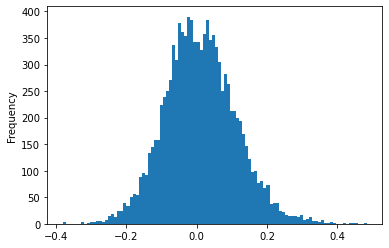

In [59]:
x1=north_table["north_consistency"].plot.hist(bins=100)
plt.savefig('northhist.png')

In [60]:
#OUTPUT----------------------------------Remove temp for final-----------------
north_table.to_csv('north_table'+load_path+'temp.csv', index=False) 
south_table.to_csv('south_table'+load_path+'temp.csv', index=False) 
east_table.to_csv('east_table'+load_path+'temp.csv', index=False) 
west_table.to_csv('west_table'+load_path+'temp.csv', index=False) 
print("Stage 5 Completed Succesfully!")
#OUTPUT-----------------------------------------------------------------------

Stage 5 Completed Succesfully!


In [8]:
#Reloading Directional Tables
north_table = pd.read_csv("north_table_final.csv") 
south_table = pd.read_csv("south_table_final.csv") 
east_table = pd.read_csv("east_table_final.csv") 
west_table = pd.read_csv("west_table_final.csv") 